# SE447 – Project #2 (Classification)  
## Vehicle Type (Vehicle Style) Multi-Class Classification using Scikit-Learn

**Goal:** Predict a car's **Vehicle Style** (e.g., Sedan, SUV, Coupe, Hatchback) based on technical specifications.  
**Dataset:** Car Features and MSRP (CooperUnion) – `data.csv`  
**Note:** MSRP is intentionally **excluded** to avoid price bias and to focus on physical/technical attributes.

> Put your team details (names + IDs + digital signatures) here and also copy them into the first Markdown cell of your submission notebook.


In [1]:
from IPython.display import display

# Core libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, roc_curve
)

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


## 1. Dataset Loading

This notebook uses the **Car Features and MSRP** dataset (`data.csv`).  
Make sure `data.csv` is in the **same folder** as this notebook, or update `DATA_PATH`.


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

# Navigate to the folder you want to work with
folder_path = '/content/drive/My Drive/Colab Notebooks/SE447_Project/'



DATA_PATH = folder_path+"data.csv"  # change if needed

df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
df.head()


Mounted at /content/drive/
Shape: (11914, 16)


,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


## 2. Understanding the Dataset

### 2.1 Target (What we predict)
- **Target column:** `Vehicle Style`  
This is a **multi-class** target (several vehicle types).

### 2.2 Features (What we use)
We will use a set of **intuitive technical features** and drop columns that:
- leak identity (e.g., Make/Model/Year),
- are not needed,
- or are too messy/high-missing for a clean baseline.

**MSRP is excluded** (as requested).


In [3]:
# Basic info
display(df.info())

# Missing values (top 15)
missing = df.isna().sum().sort_values(ascending=False)
display(missing.head(15))

# Target distribution (top 15 classes)
target_col = "Vehicle Style"
display(df[target_col].value_counts().head(15))
print("Number of classes:", df[target_col].nunique())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11914 entries, 0 to 11913
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Make               11914 non-null  object 
 1   Model              11914 non-null  object 
 2   Year               11914 non-null  int64  
 3   Engine Fuel Type   11911 non-null  object 
 4   Engine HP          11845 non-null  float64
 5   Engine Cylinders   11884 non-null  float64
 6   Transmission Type  11914 non-null  object 
 7   Driven_Wheels      11914 non-null  object 
 8   Number of Doors    11908 non-null  float64
 9   Market Category    8172 non-null   object 
 10  Vehicle Size       11914 non-null  object 
 11  Vehicle Style      11914 non-null  object 
 12  highway MPG        11914 non-null  int64  
 13  city mpg           11914 non-null  int64  
 14  Popularity         11914 non-null  int64  
 15  MSRP               11914 non-null  int64  
dtypes: float64(3), int64(5

None

,0
Market Category,3742
Engine HP,69
Engine Cylinders,30
Number of Doors,6
Engine Fuel Type,3
Model,0
Year,0
Make,0
Driven_Wheels,0
Transmission Type,0


,count
Vehicle Style,
Sedan,3048
4dr SUV,2488
Coupe,1211
Convertible,793
4dr Hatchback,702
Crew Cab Pickup,681
Extended Cab Pickup,623
Wagon,592
2dr Hatchback,506


Number of classes: 16


## 3. Feature Selection + Cleaning Decisions

### Dropped columns (and why)
- `MSRP`: excluded to avoid price bias
- `Make`, `Model`, `Year`: identity-like columns → can cause leakage / memorization
- `Market Category`: many missing values and messy comma-separated labels (optional feature; dropped for a clean baseline)

### Selected columns
- Numeric: `Engine HP`, `Engine Cylinders`, `Number of Doors`, `highway MPG`, `city mpg`, `Popularity`
- Categorical: `Engine Fuel Type`, `Transmission Type`, `Driven_Wheels`, `Vehicle Size`

If you want to expand later, `Market Category` can be added, but we keep the first version simple and strong.


In [4]:
# Columns to drop
drop_cols = ["MSRP", "Make", "Model", "Year", "Market Category"]

# Selected features
target_col = "Vehicle Style"
feature_cols = [
    "Engine Fuel Type",
    "Engine HP",
    "Engine Cylinders",
    "Transmission Type",
    "Driven_Wheels",
    "Number of Doors",
    "Vehicle Size",
    "highway MPG",
    "city mpg",
    "Popularity"
]

# Keep only needed columns
data = df[feature_cols + [target_col]].copy()
print("Working data shape:", data.shape)
data.head()


Working data shape: (11914, 11)


,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Vehicle Size,highway MPG,city mpg,Popularity,Vehicle Style
0,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,Compact,26,19,3916,Coupe
1,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,Compact,28,19,3916,Convertible
2,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,Compact,28,20,3916,Coupe
3,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Compact,28,18,3916,Coupe
4,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Compact,28,18,3916,Convertible


## 4. Train/Test Split (Option 2)

We will merge everything (already in one file) and do our own split using:
- `train_test_split` with `stratify=y` (preserves class distribution)
- `test_size = 20%`

This matches the **Option 2** approach you requested.


In [5]:
X = data[feature_cols]
y_raw = data[target_col]

# Encode labels for ROC-AUC computations (multi-class)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_raw)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=RANDOM_STATE,
    stratify=y
)

print("Train size:", X_train.shape, "Test size:", X_test.shape)
print("Classes:", len(label_encoder.classes_))


Train size: (9531, 10) Test size: (2383, 10)
Classes: 16


## 5. Preprocessing Pipeline (Clean + Reusable)

We use a single preprocessing pipeline for all models:

- **Numeric columns**
  - Impute missing values with **median**
  - Scale using **StandardScaler**
- **Categorical columns**
  - Impute missing values with **most frequent**
  - One-Hot Encode using **OneHotEncoder**

This is standard, professional practice in scikit-learn (and avoids leakage).


In [6]:
numeric_features = ["Engine HP", "Engine Cylinders", "Number of Doors", "highway MPG", "city mpg", "Popularity"]
categorical_features = ["Engine Fuel Type", "Transmission Type", "Driven_Wheels", "Vehicle Size"]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

preprocessor


ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['Engine HP', 'Engine Cylinders',
                                  'Number of Doors', 'highway MPG', 'city mpg',
                                  'Popularity']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Engine Fuel Type', 'Transmission Type',
                                  'Driven_Wheels', 'Vehicle Size'])])

## 6. Models Implemented (5 Models)

We train and compare the following classifiers:

1. Logistic Regression (baseline, strong linear model)
2. KNN (instance-based)
3. SVM (non-linear, RBF kernel)
4. Decision Tree (rule-based)
5. Neural Network (MLP)

All models are trained using the **same preprocessing pipeline**, ensuring a fair comparison.


In [7]:
models = {
    "Logistic Regression": LogisticRegression(
        max_iter=2000,
        n_jobs=None,
        multi_class="auto",
        class_weight="balanced",
        random_state=RANDOM_STATE
    ),
    "KNN": KNeighborsClassifier(
        n_neighbors=15
    ),
    "SVM (RBF)": SVC(
        kernel="rbf",
        C=5.0,
        gamma="scale",
        probability=True,  # needed for ROC-AUC
        class_weight="balanced",
        random_state=RANDOM_STATE
    ),
    "Decision Tree": DecisionTreeClassifier(
        max_depth=18,
        random_state=RANDOM_STATE,
        class_weight="balanced"
    ),
    "Neural Network (MLP)": MLPClassifier(
        hidden_layer_sizes=(128, 64),
        activation="relu",
        solver="adam",
        max_iter=300,
        random_state=RANDOM_STATE,
        early_stopping=True
    )
}

pipelines = {
    name: Pipeline(steps=[("preprocess", preprocessor), ("model", mdl)])
    for name, mdl in models.items()
}

list(pipelines.keys())


['Logistic Regression',
 'KNN',
 'SVM (RBF)',
 'Decision Tree',
 'Neural Network (MLP)']

## 7. Evaluation Functions

For each model we compute:
- Accuracy
- Precision (macro)
- Recall (macro)
- F1-score (macro)
- Confusion Matrix
- ROC-AUC (macro, One-vs-Rest) where probabilities are available

**Why macro?**  
Macro treats each class equally (important in multi-class tasks with imbalance).


In [8]:
from collections import defaultdict

def evaluate_model(name, pipe, X_train, y_train, X_test, y_test, label_encoder):
    # Train
    pipe.fit(X_train, y_train)

    # Predict
    y_pred = pipe.predict(X_test)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average="macro", zero_division=0)
    rec = recall_score(y_test, y_pred, average="macro", zero_division=0)
    f1 = f1_score(y_test, y_pred, average="macro", zero_division=0)

    # ROC-AUC (multi-class OvR) if proba available
    roc_auc = np.nan
    y_proba = None
    if hasattr(pipe.named_steps["model"], "predict_proba"):
        y_proba = pipe.predict_proba(X_test)
        roc_auc = roc_auc_score(y_test, y_proba, multi_class="ovr", average="macro")

    return {
        "Model": name,
        "Accuracy": acc,
        "Precision (Macro)": prec,
        "Recall (Macro)": rec,
        "F1 (Macro)": f1,
        "ROC-AUC (Macro, OvR)": roc_auc,
        "y_pred": y_pred,
        "y_proba": y_proba,
        "pipe": pipe
    }

results = []


## 8. Train + Evaluate All Models

In [9]:
for name, pipe in pipelines.items():
    print(f"Training: {name}")
    res = evaluate_model(name, pipe, X_train, y_train, X_test, y_test, label_encoder)
    results.append(res)

# Summary table
summary = pd.DataFrame([{k:v for k,v in r.items() if k not in ["y_pred", "y_proba", "pipe"]} for r in results])
summary = summary.sort_values(by="F1 (Macro)", ascending=False).reset_index(drop=True)
summary


Training: Logistic Regression


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Training: KNN
Training: SVM (RBF)
Training: Decision Tree
Training: Neural Network (MLP)


,Model,Accuracy,Precision (Macro),Recall (Macro),F1 (Macro),"ROC-AUC (Macro, OvR)"
0,Decision Tree,0.847671,0.804567,0.865593,0.828437,0.970075
1,Neural Network (MLP),0.739824,0.722738,0.690753,0.693111,0.980509
2,KNN,0.710449,0.676464,0.659225,0.659926,0.978812
3,SVM (RBF),0.649601,0.604421,0.734556,0.630575,0.978115
4,Logistic Regression,0.566093,0.501659,0.663040,0.531337,0.957816


## 9. Winner Selection

We select the winner primarily using **Macro F1-score** (balanced performance across classes).  
Accuracy alone can hide poor performance on minority classes.


In [10]:
best_model_name = summary.loc[0, "Model"]
best_row = next(r for r in results if r["Model"] == best_model_name)

print("Best model:", best_model_name)
best_row


Best model: Decision Tree


{'Model': 'Decision Tree',
 'Accuracy': 0.8476710029374738,
 'Precision (Macro)': 0.8045670132913568,
 'Recall (Macro)': 0.8655932281315637,
 'F1 (Macro)': 0.8284365948397416,
 'ROC-AUC (Macro, OvR)': np.float64(0.970075105362203),
 'y_pred': array([ 6,  9,  3, ...,  6, 14, 10]),
 'y_proba': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'pipe': Pipeline(steps=[('preprocess',
                  ColumnTransformer(transformers=[('num',
                                                   Pipeline(steps=[('imputer',
                                                                    SimpleImputer(strategy='median')),
                                                                   ('scaler',
                                                                    StandardScaler())]),
            

## 10. Confusion Matrices (All Models)

A confusion matrix shows where the model is confusing one vehicle style for another.


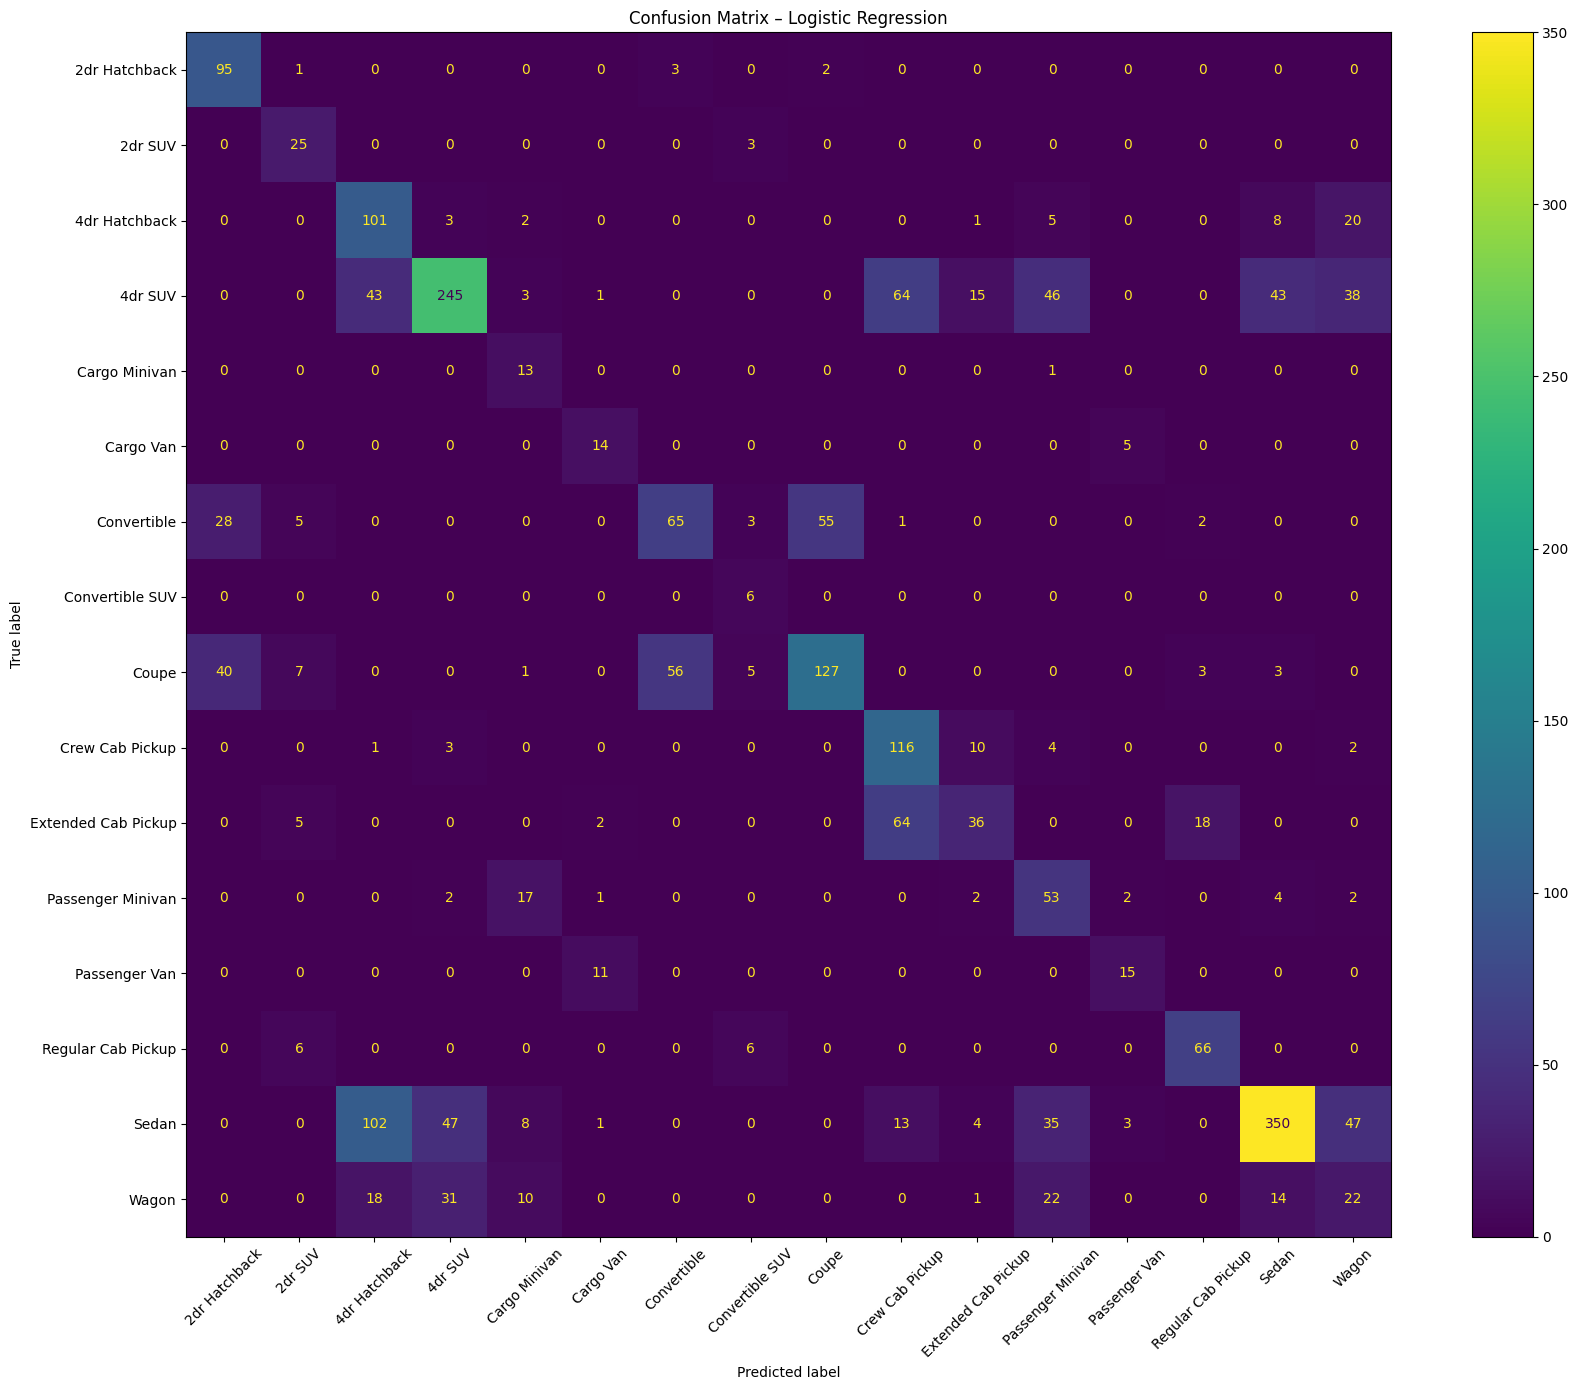

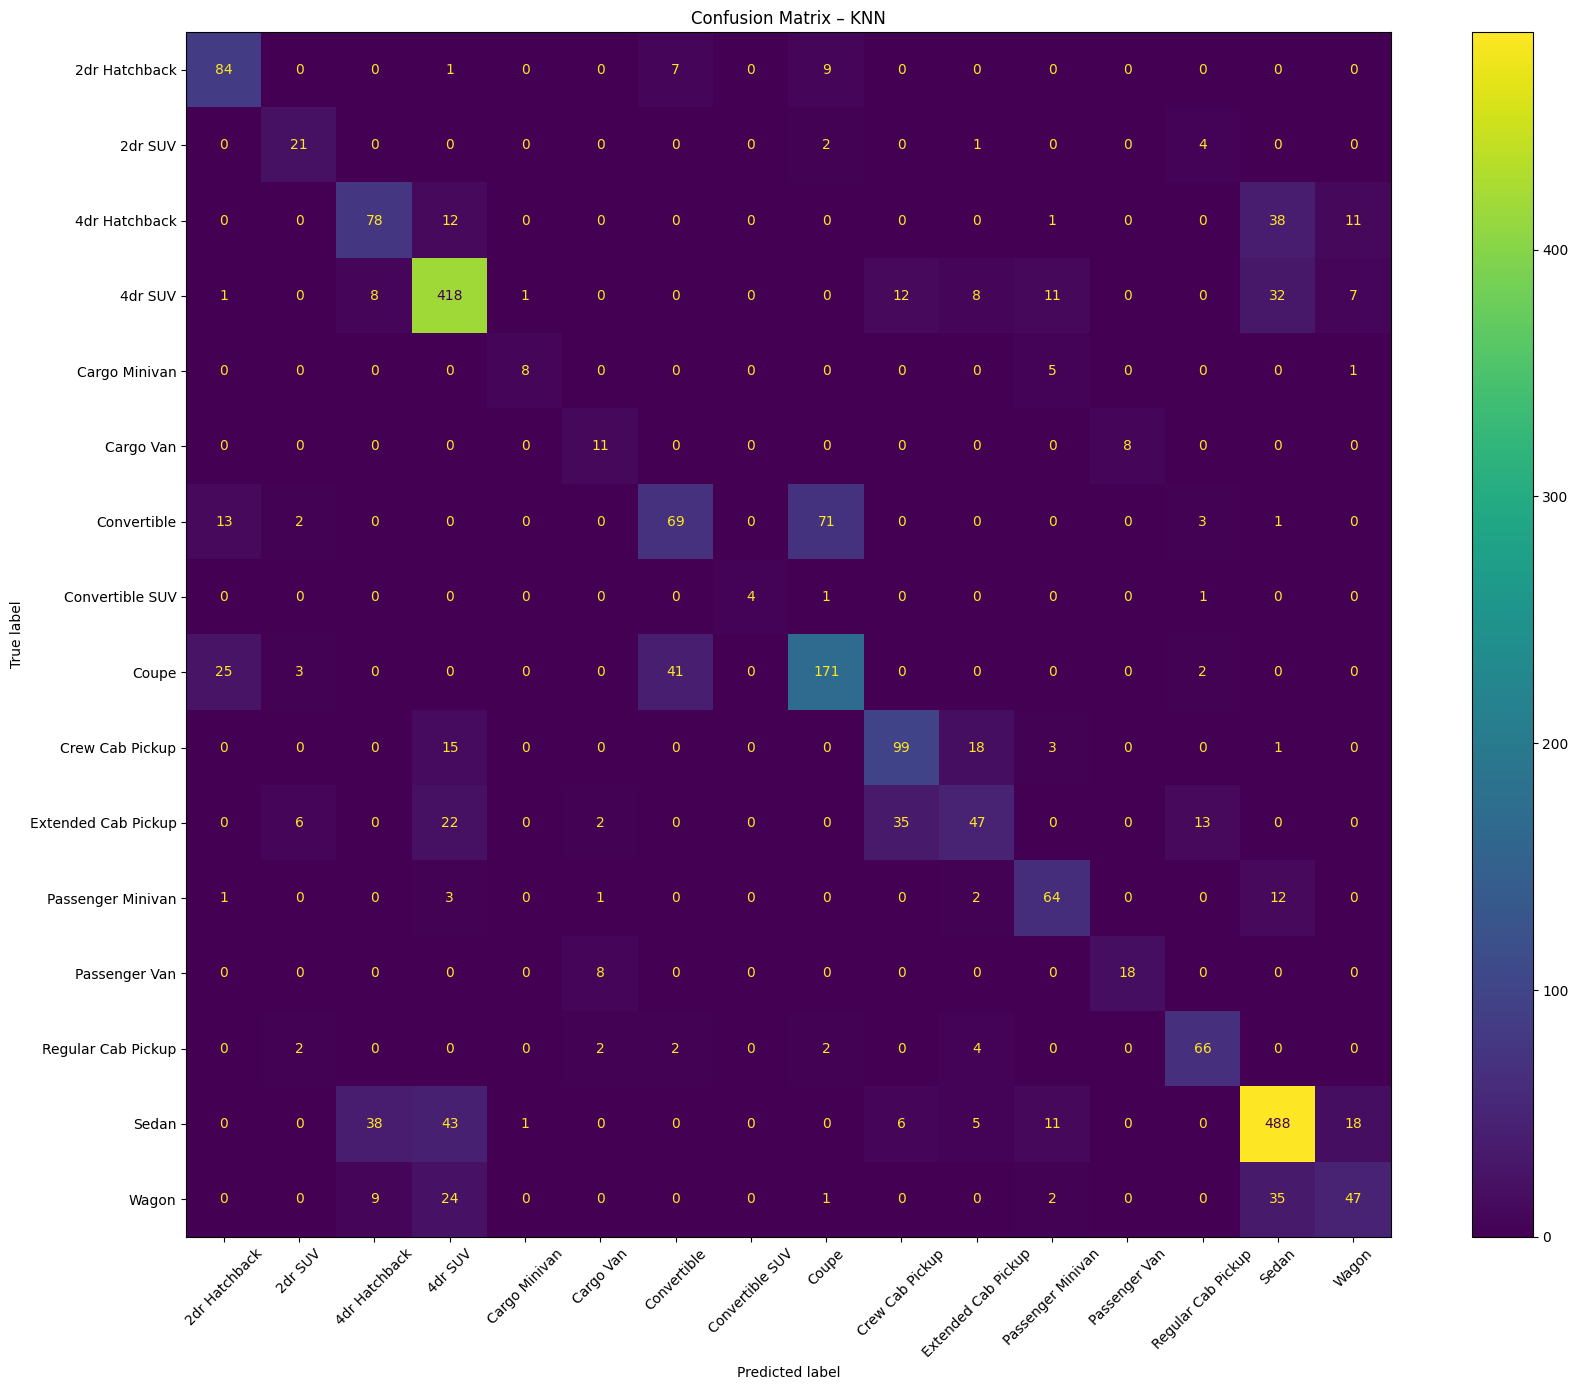

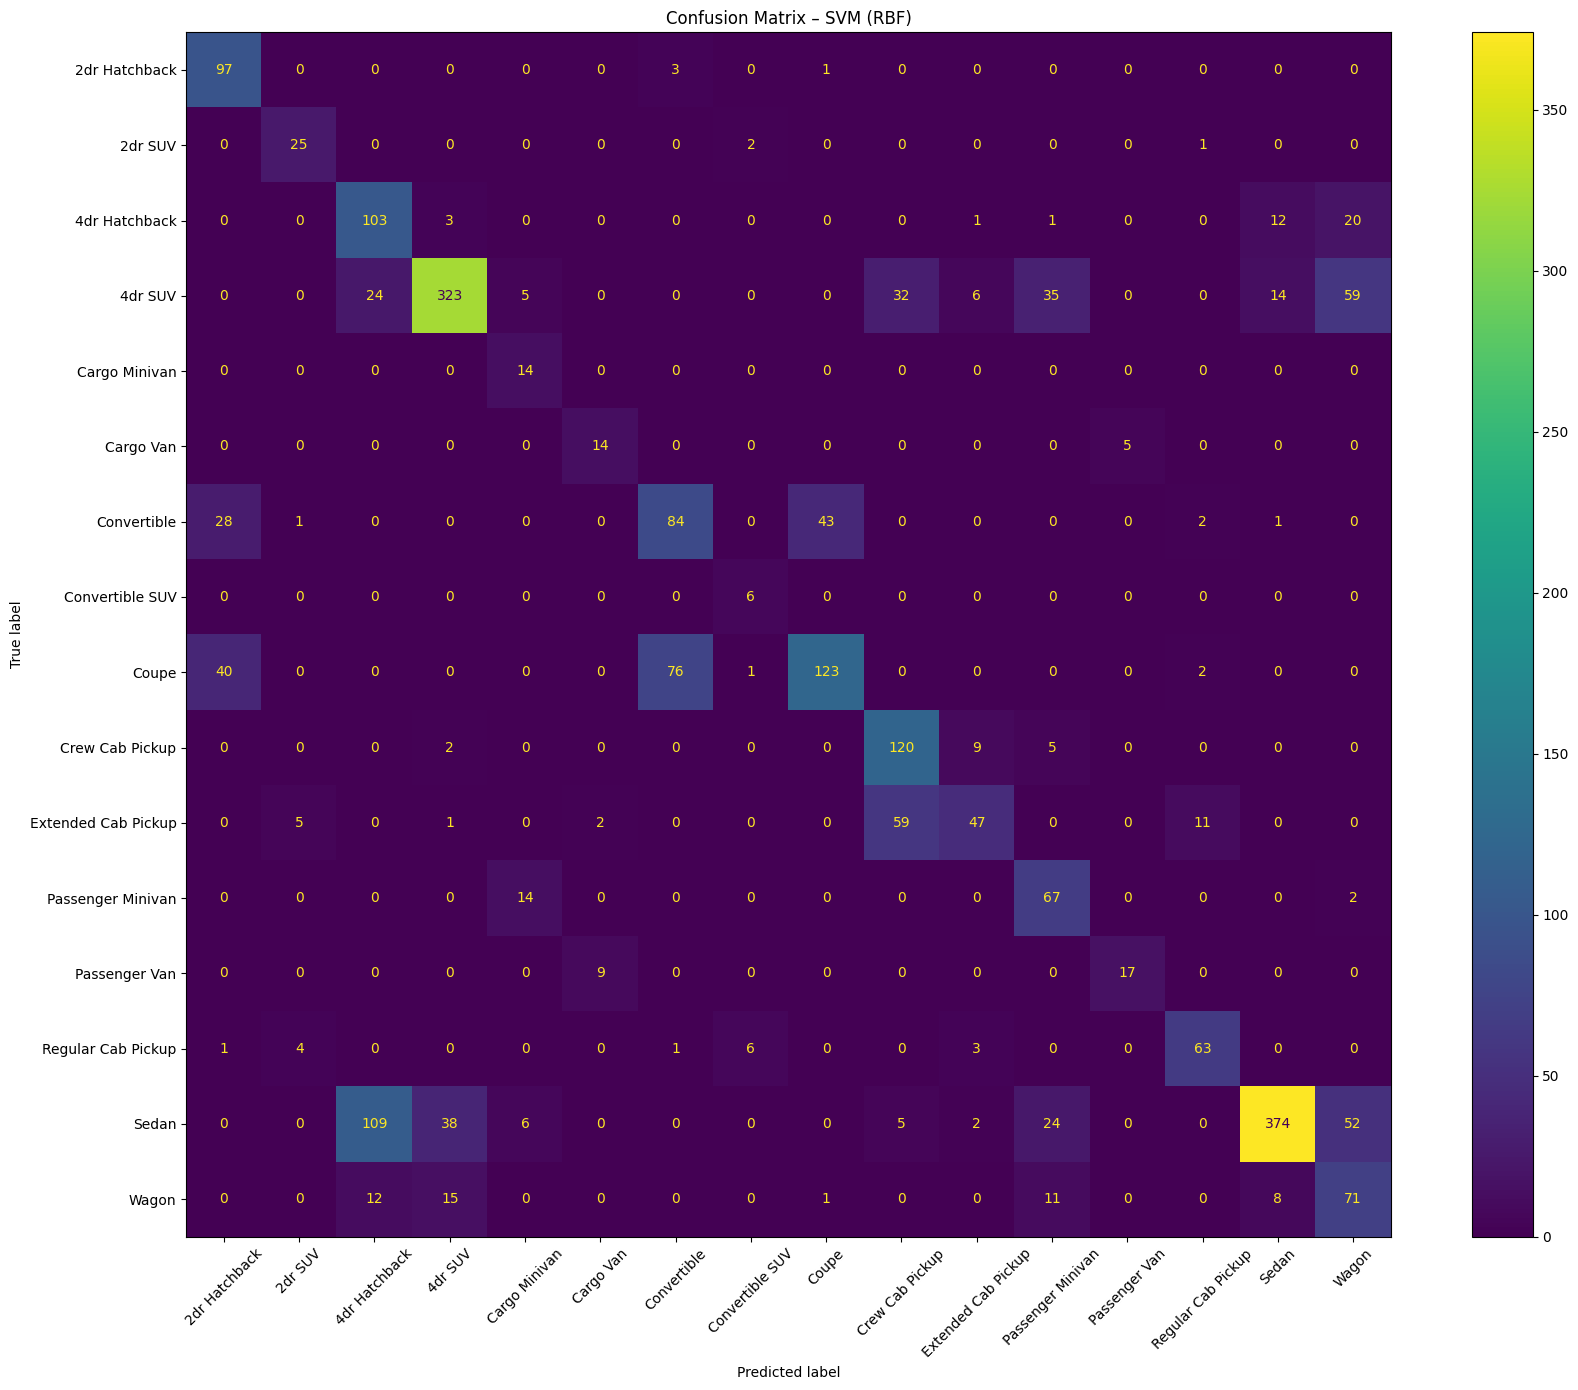

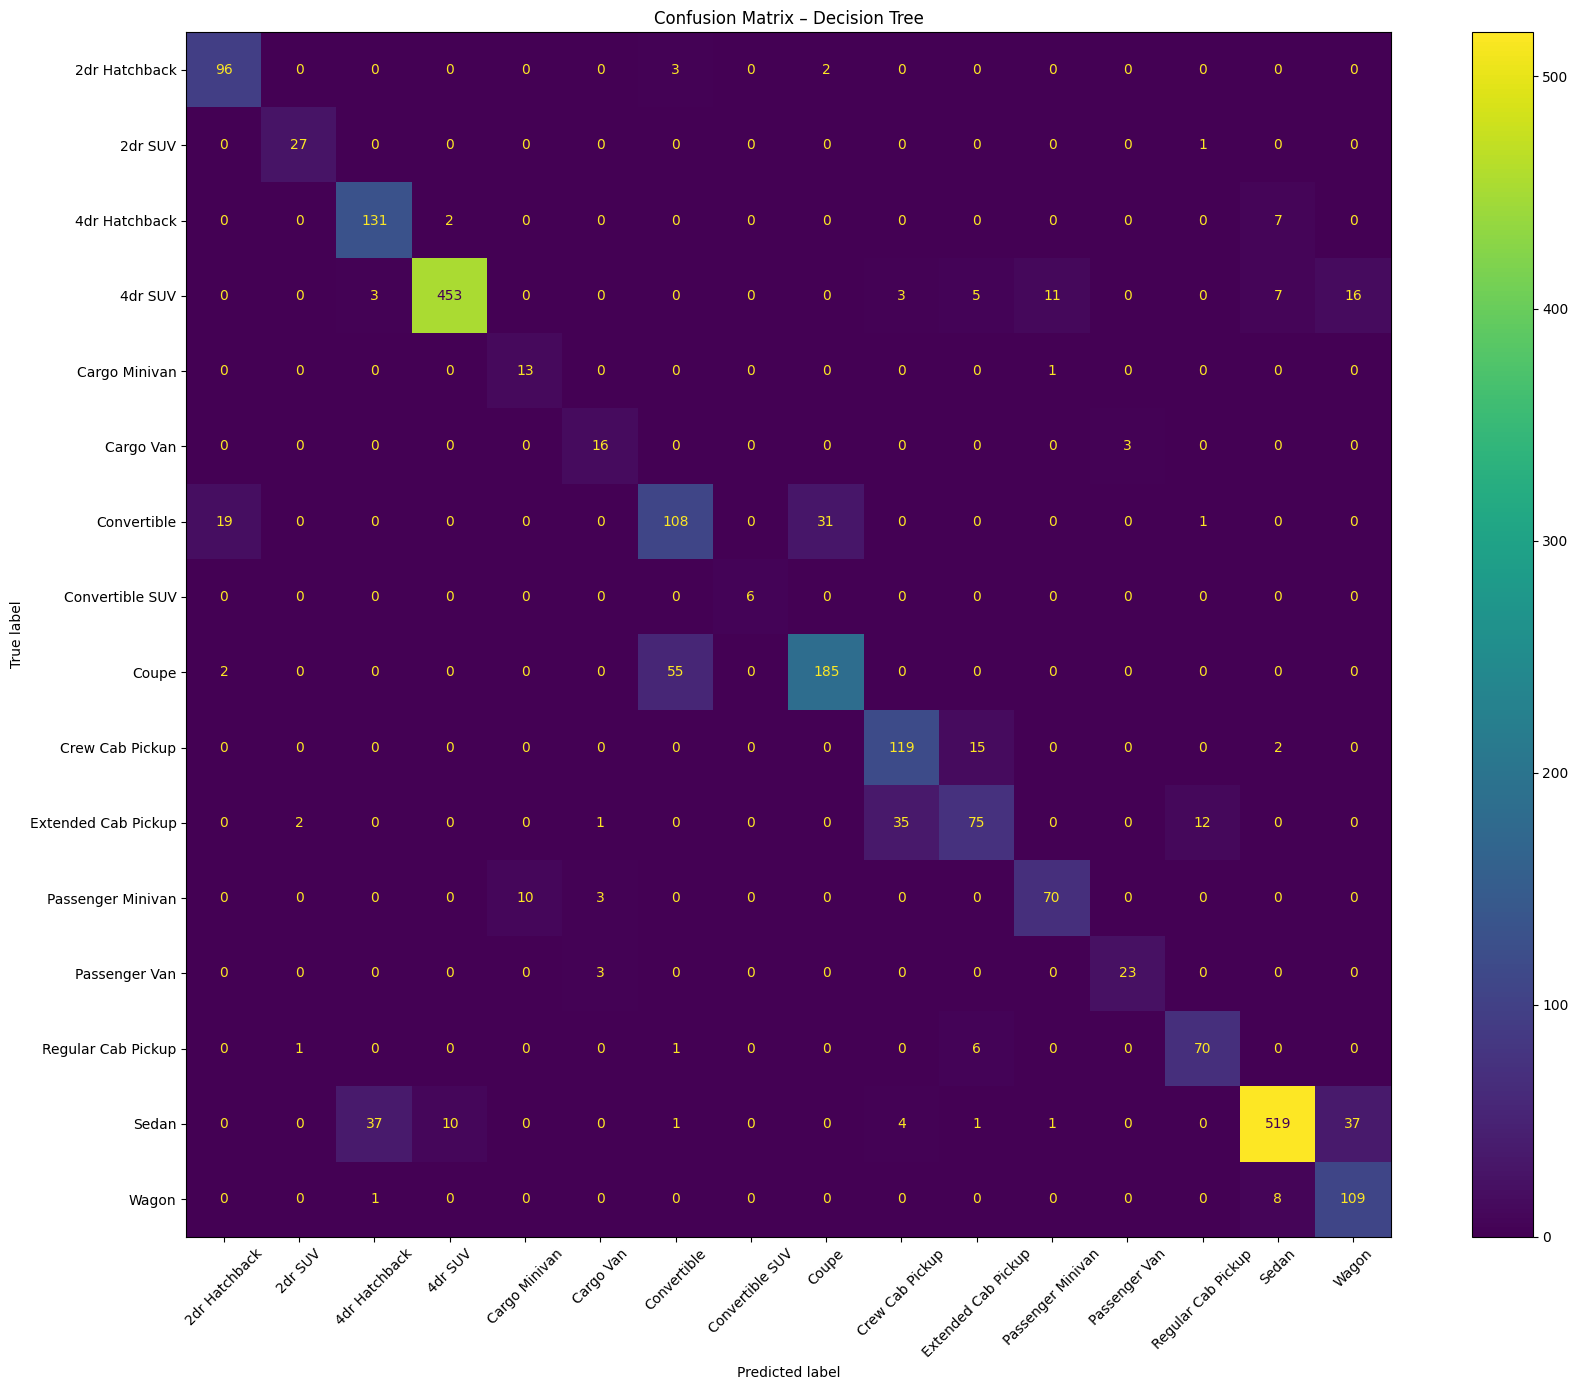

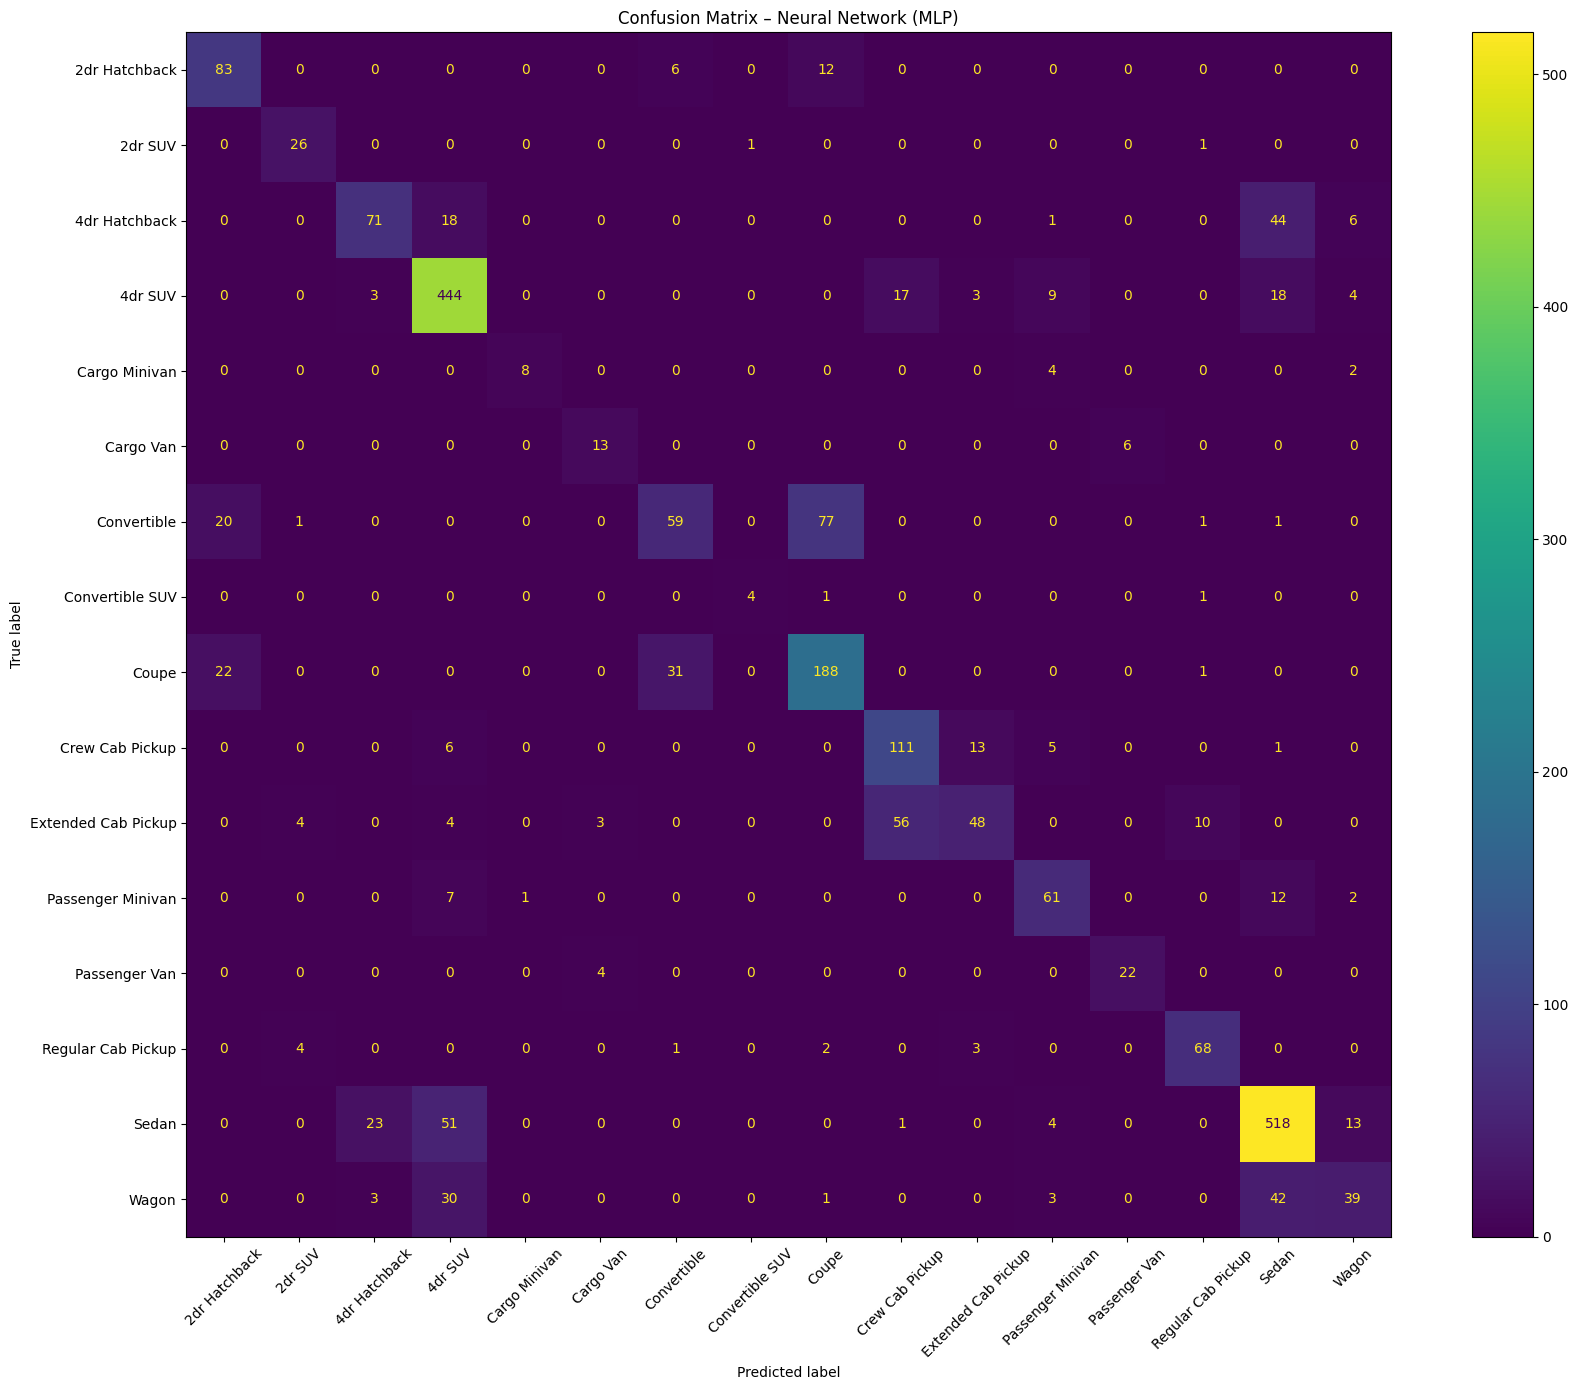

In [11]:
class_names = label_encoder.classes_
labels = list(range(len(class_names)))   # enforce fixed class order

for r in results:
    name = r["Model"]
    y_pred = r["y_pred"]

    cm = confusion_matrix(y_test, y_pred, labels=labels)

    fig, ax = plt.subplots(figsize=(18, 14))  # bigger = readable
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(ax=ax, xticks_rotation=45, values_format="d", cmap="viridis", colorbar=True)

    ax.set_title(f"Confusion Matrix – {name}")
    plt.tight_layout()
    plt.show()


## 11. Detailed Classification Reports

This includes per-class precision/recall/F1.


In [12]:
for r in results:
    name = r["Model"]
    y_pred = r["y_pred"]
    print("="*90)
    print(name)
    print(classification_report(
        y_test, y_pred,
        target_names=class_names,
        zero_division=0
    ))


Logistic Regression
                     precision    recall  f1-score   support

      2dr Hatchback       0.58      0.94      0.72       101
            2dr SUV       0.51      0.89      0.65        28
      4dr Hatchback       0.38      0.72      0.50       140
            4dr SUV       0.74      0.49      0.59       498
      Cargo Minivan       0.24      0.93      0.38        14
          Cargo Van       0.47      0.74      0.57        19
        Convertible       0.52      0.41      0.46       159
    Convertible SUV       0.26      1.00      0.41         6
              Coupe       0.69      0.52      0.60       242
    Crew Cab Pickup       0.45      0.85      0.59       136
Extended Cab Pickup       0.52      0.29      0.37       125
  Passenger Minivan       0.32      0.64      0.43        83
      Passenger Van       0.60      0.58      0.59        26
 Regular Cab Pickup       0.74      0.85      0.79        78
              Sedan       0.83      0.57      0.68       610
   

## 12. ROC Curves (Where Applicable)

ROC is originally for binary classification.  
For multi-class, we use **One-vs-Rest (OvR)** ROC and report **macro-average AUC**.

To keep plots readable, we plot ROC curves for the **top 6 most frequent classes** in the test set.


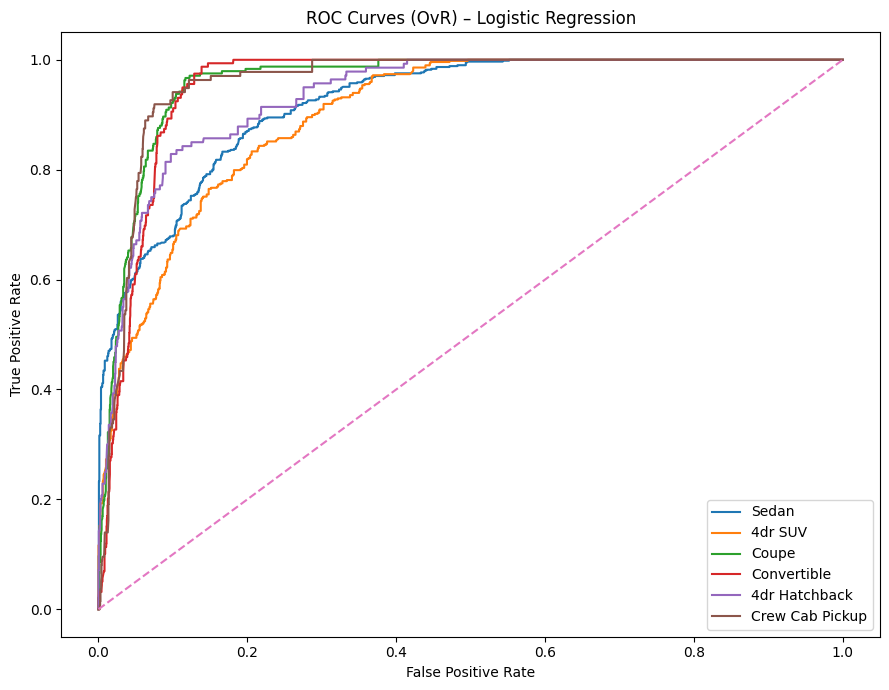

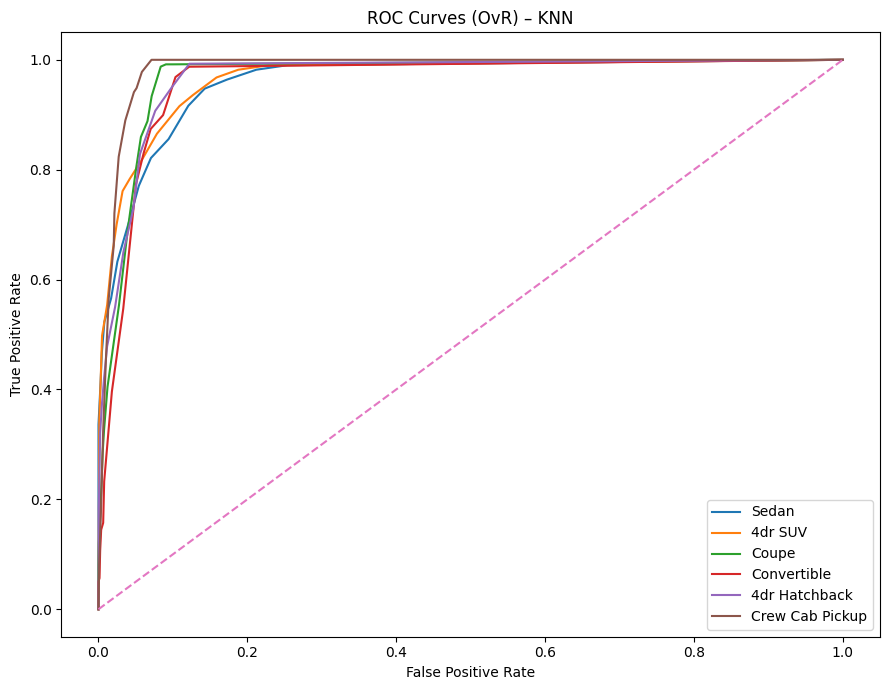

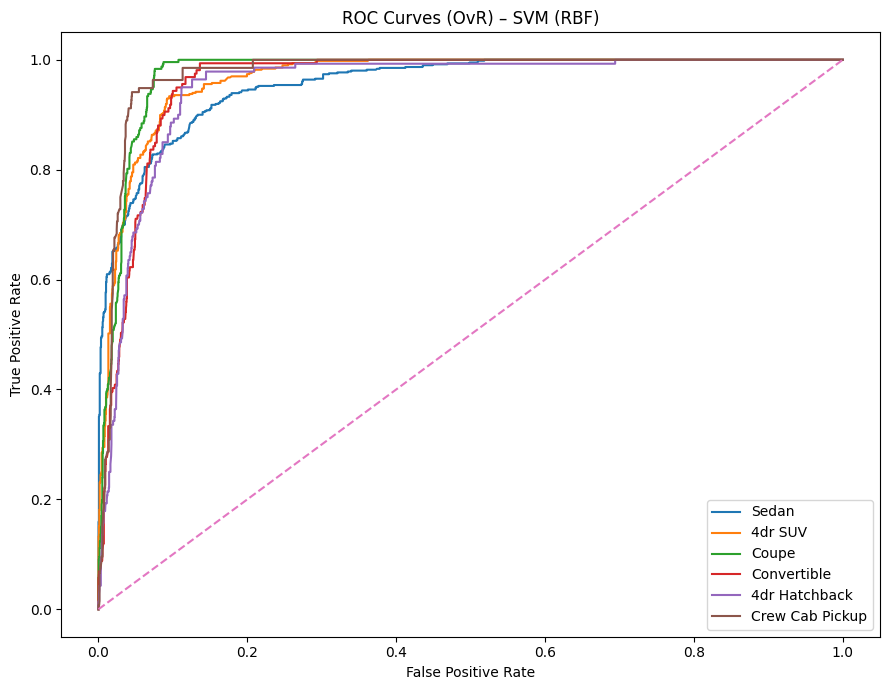

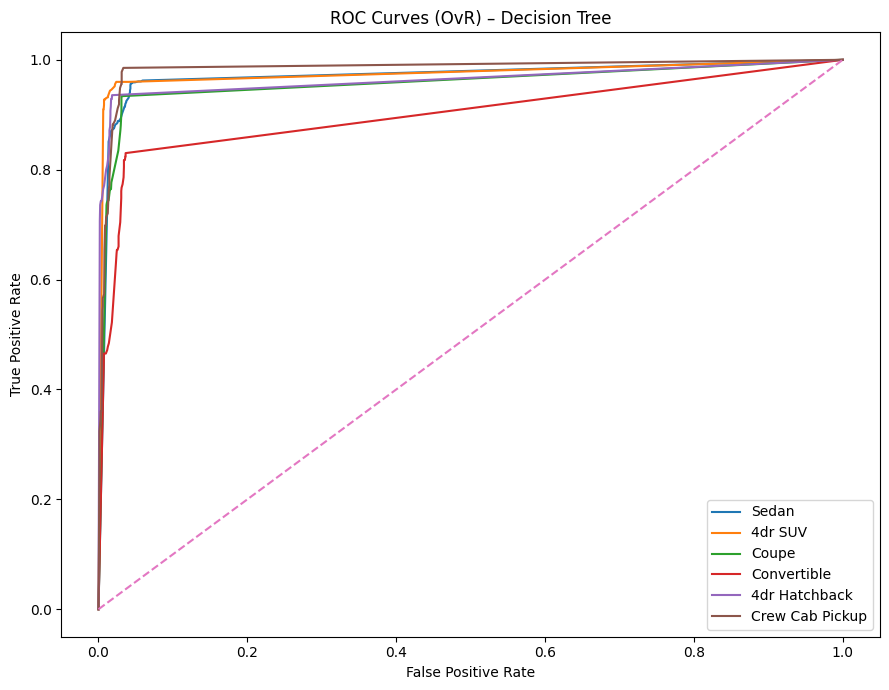

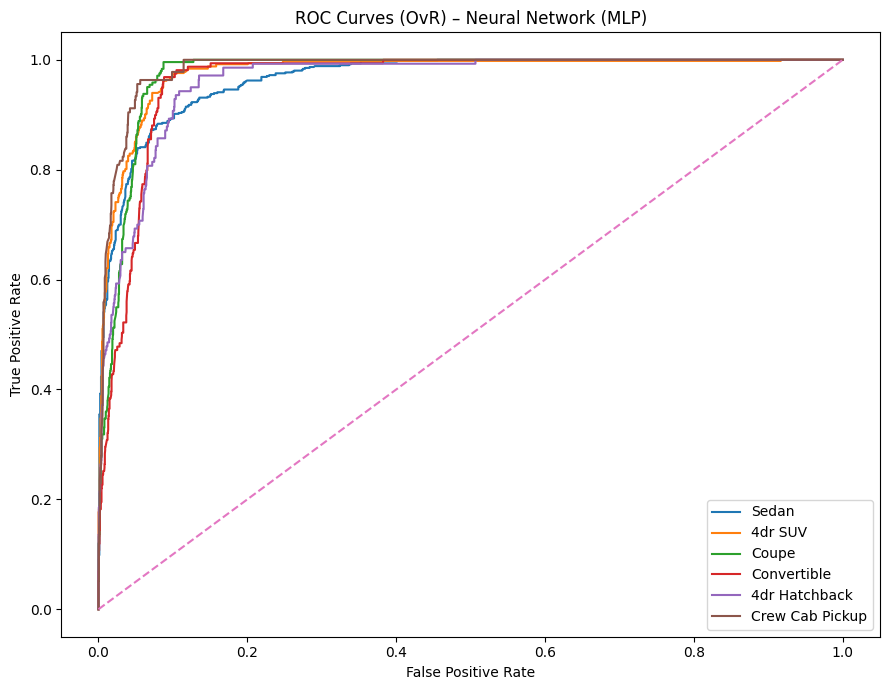

In [13]:
# Choose top classes by frequency in y_test
test_counts = pd.Series(y_test).value_counts().sort_values(ascending=False)
top_k = min(6, len(class_names))
top_classes = test_counts.index[:top_k].tolist()
top_class_names = [class_names[i] for i in top_classes]

def plot_multiclass_roc(name, y_test, y_proba, classes_to_plot):
    plt.figure(figsize=(9, 7))
    for cls in classes_to_plot:
        # Binary ground truth for this class
        y_true_binary = (y_test == cls).astype(int)
        y_score = y_proba[:, cls]
        fpr, tpr, _ = roc_curve(y_true_binary, y_score)
        plt.plot(fpr, tpr, label=class_names[cls])
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curves (OvR) – {name}")
    plt.legend()
    plt.tight_layout()
    plt.show()

for r in results:
    name = r["Model"]
    y_proba = r["y_proba"]
    if y_proba is None:
        continue
    plot_multiclass_roc(name, y_test, y_proba, top_classes)


## 13. Side-by-Side Comparison Table

This table is what you will reference in the **Results** and **Discussion** sections of the report.


In [14]:
# Display with formatting
summary_display = summary.copy()
for col in ["Accuracy", "Precision (Macro)", "Recall (Macro)", "F1 (Macro)", "ROC-AUC (Macro, OvR)"]:
    summary_display[col] = summary_display[col].astype(float).round(4)

summary_display


,Model,Accuracy,Precision (Macro),Recall (Macro),F1 (Macro),"ROC-AUC (Macro, OvR)"
0,Decision Tree,0.8477,0.8046,0.8656,0.8284,0.9701
1,Neural Network (MLP),0.7398,0.7227,0.6908,0.6931,0.9805
2,KNN,0.7104,0.6765,0.6592,0.6599,0.9788
3,SVM (RBF),0.6496,0.6044,0.7346,0.6306,0.9781
4,Logistic Regression,0.5661,0.5017,0.6630,0.5313,0.9578


## 14. Conclusion (Notebook Summary)

- We built a **multi-class** vehicle-style classifier using real car specification data.
- MSRP was excluded to focus on physical/technical attributes.
- We trained and compared **5 models** using consistent preprocessing.
- We selected the best model using **Macro F1** (balanced multi-class performance).

Next steps (Future Work ideas you can use in the report):
- Add `Market Category` using better text preprocessing (split comma-separated categories)
- Hyperparameter tuning (GridSearchCV / RandomizedSearchCV)
- Address class imbalance with resampling or advanced class weights
- Try ensemble models (Random Forest, Gradient Boosting, XGBoost)
